In [1]:
from fastai2.vision.all import *

In [3]:
# Chargement d'un jeux de données: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/
path = untar_data(URLs.PASCAL_2007)

# Les labels sont fournis dans un fichier CSV
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [9]:
def get_x(r): return path/'train'/r['fname'] # Chemin vers l'image.
def get_y(r): return r['labels'].split(' ') # Catégories séparées par des espaces.

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/storage/data/pascal_2007/train/004537.jpg'),
 ['horse', 'cow', 'person'])

In [17]:
def get_x(r): return path/'train'/r['fname'] # Chemin vers l'image.
def get_y(r): return r['labels'].split(' ') # Catégories séparées par des espaces.

# On détermine comment séparer les données d'entrainement et de validation (indiqué dans le fichier)
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

# On remplace par l'utilisation des DataBlocks
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                  splitter=splitter,
                  get_x = get_x, 
                  get_y = get_y,
                  item_tfms = RandomResizedCrop(128, min_scale=0.35)) # On redimensionne les images
dsets = dblock.datasets(df)
dsets.train[0]

# On récupére une image en entrée et un système one hot encoding de catégories 1 ou 0 pour chaque. 

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [15]:
# On peut récupérerer la liste des catégories crées. 
dsets.train.vocab

(#20) ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow'...]

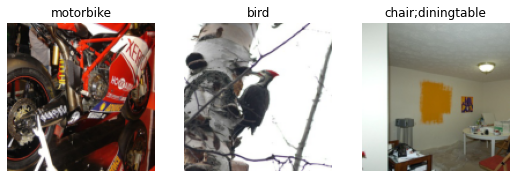

In [19]:
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

In [21]:
learn = cnn_learner(dls, resnet18)

In [23]:
# On crée un model (cnn_learner pour les images) avec un réseau resnet18. 

learn = cnn_learner(dls, resnet18)

# On applique le model sur un batch d'image pour voir un peu ce qu'il se passe

x,y = dls.train.one_batch()
activs = learn.model(x)
activs.shape,activs[0]

# En sortie (activation) on récupère 20 nombres (un par catégorie) indiquant la prédiction pour cette catégorie. 

(torch.Size([64, 20]),
 tensor([ 0.4936, -0.7682, -0.1579,  2.8584,  2.4323, -1.0062, -1.0234,  0.2495,
         -0.7605,  0.1707,  3.6127,  0.2475, -1.2885,  0.7810, -3.7667,  0.1150,
         -0.4220,  0.2966, -0.6514, -0.8126], device='cuda:0',
        grad_fn=<SelectBackward>))

In [24]:
# Dans le cas d'un problème multicatégorie il nous faut adapter la fonction de calcul de performance. 
# Le but n'est plus de trouvé la bonne catégorie, il peut y en avoir plusieurs. Nous allons donc fixer un seuil à partir 
# duquel on considére qu'une catégorie est "trouvée"

def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid() # On ramene la prédiction entre 0 et 1
    return ((inp>thresh) == targ.bool()).float().mean()

# Si la prédiction est supérieur au seuil on considére que la catégories est bien à trouver. 

In [25]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.990409,0.734842,0.189960,00:38
1,0.873666,0.579062,0.229621,00:08
2,0.646038,0.215325,0.805498,00:07
3,0.391834,0.142975,0.933506,00:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.155390,0.126379,0.937948,00:07
1,0.136872,0.118463,0.943884,00:08
2,0.120717,0.116985,0.943904,00:08


In [27]:
# On peut tester d'autre seuil (0.1 ici)
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.11698546260595322,0.9170715808868408]

In [28]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.11698546260595322,0.9368327260017395]

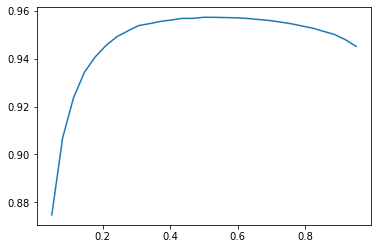

In [29]:
# On voit que cela à un impact. Il faut donc le régler. On peut tester les différentes valeurs pour trouver la meilleure

# On récupére le résultat du modèle. 
preds,targs = learn.get_preds()

# On peut tracer la courbe du taux de performance en fonction du seuil
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);